In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gplately
from scipy import ndimage
from scipy.spatial import cKDTree


# agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/SampleData/Rasters/M2020_AgeGrids/"
# agegrid_filename = agegrid_dir + "Muller_etal_2019_Tectonics_v2.0_AgeGrid-{:.0f}.nc"

agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = agegrid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"

reconstruction_times = np.arange(0,171)

In [2]:
# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Clennett2020")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [3]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0 #Ma
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [4]:
def grad(raster, tol_grad=2, iter_dilation=2, mask=True):
    image = raster.fill_NaNs()
    gradX, gradY = np.gradient(image)
    gradXY = np.hypot(gradX, gradY)
    
    mask_fz = gradXY > tol_grad

    fz_grid = np.zeros(mask_fz.shape)
    fz_grid[mask_fz] = 1
    
    if iter_dilation:
        fz_grid = ndimage.binary_dilation(fz_grid, iterations=iter_dilation)
    
    if mask:
        fz_grid[raster.data.mask] = np.nan
        
    fz_raster = gplately.Raster(array=fz_grid, extent='global')    
    
    return fz_raster

In [5]:
def reconstruct_fracture_zones(time, return_grid=False):
    subduction_data = model.tesselate_subduction_zones(time, np.deg2rad(0.2), ignore_warnings=True)
    trench_lons = subduction_data[:,0]
    trench_lats = subduction_data[:,1]
    trench_norm = subduction_data[:,7]
    
    dlon = -1*np.sin(np.radians(trench_norm))
    dlat = -1*np.cos(np.radians(trench_norm))
    
    trench_lons += dlon
    trench_lats += dlat
    
    agegrid_raster = gplately.Raster(filename=agegrid_filename.format(time))
    fz_raster = grad(agegrid_raster, tol_grad=2, iter_dilation=2, mask=False)
    
    trench_fz = fz_raster.interpolate(trench_lons, trench_lats, method='nearest')
    
    # mask points where fracture zone intersects a subduction zone
    mask_trench_fz = trench_fz > 0
    trench_fz   = trench_fz[mask_trench_fz]
    trench_lons = trench_lons[mask_trench_fz]
    trench_lats = trench_lats[mask_trench_fz]
    
    if return_grid:
        return trench_lons, trench_lats, fz_raster.data
    else:
        return trench_lons, trench_lats

In [6]:
time = 0

fz_lons, fz_lats, fz_grid = reconstruct_fracture_zones(time, return_grid=True)

(None, None)

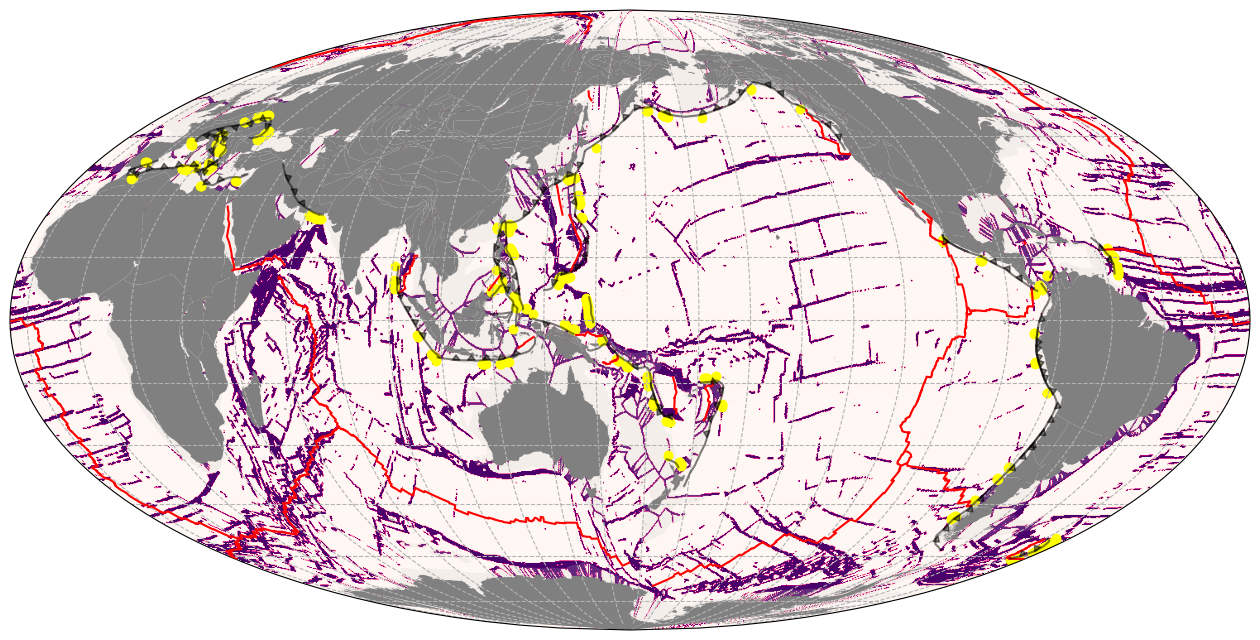

In [7]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 160))
ax.set_global()
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = time # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_grid(ax, fz_grid, origin='lower', cmap='RdPu', vmin=0, vmax=1)
gplot.plot_continents(ax, facecolor='0.8', alpha=0.2)
gplot.plot_coastlines(ax, color='0.5')
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

ax.scatter(fz_lons, fz_lats, c='yellow', transform=ccrs.PlateCarree())

gplot.plot_trenches(ax, color='k', zorder=9, alpha=0.5)
gplot.plot_subduction_teeth(ax, color='k', zorder=10, alpha=0.5)



Create a loop

In [8]:
from joblib import Parallel, delayed

In [9]:
# Use LokyBackend to protect the netCDF routine
fz_data = Parallel(n_jobs=-3, backend='loky', verbose=1)\
(delayed(reconstruct_fracture_zones) (time,) for time in reconstruction_times)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
/Users/ben/miniforge3/envs/mapping/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-3)]: Done 171 out of 171 | elapsed:  2.0min finished


In [10]:
# initialise grid

age_raster = gplately.Raster(filename=agegrid_filename.format(0))

lonq, latq = np.meshgrid(np.linspace(-180,180,age_raster.data.shape[1]),
                         np.linspace(-90, 90, age_raster.data.shape[0]))

lonq_ = lonq.ravel()
latq_ = latq.ravel()

tree_fz = cKDTree(np.c_[lonq_, latq_])

In [11]:
# iterate through time series and interpolate to subducted grid

subducted_fz_grid      = np.zeros(age_raster.data.shape, dtype=int)
subducted_fz_time_grid = np.zeros(age_raster.data.shape)

for i, time in enumerate(reconstruction_times):
    fz_lons, fz_lats = fz_data[i]
    dist, neighbours = tree_fz.query(np.c_[fz_lons, fz_lats], k=9)
    for c in range(neighbours.shape[1]):
        subducted_fz_grid.flat[neighbours[:,c]] = 1
        subducted_fz_time_grid.flat[neighbours[:,c]] = time
        

(None, None)

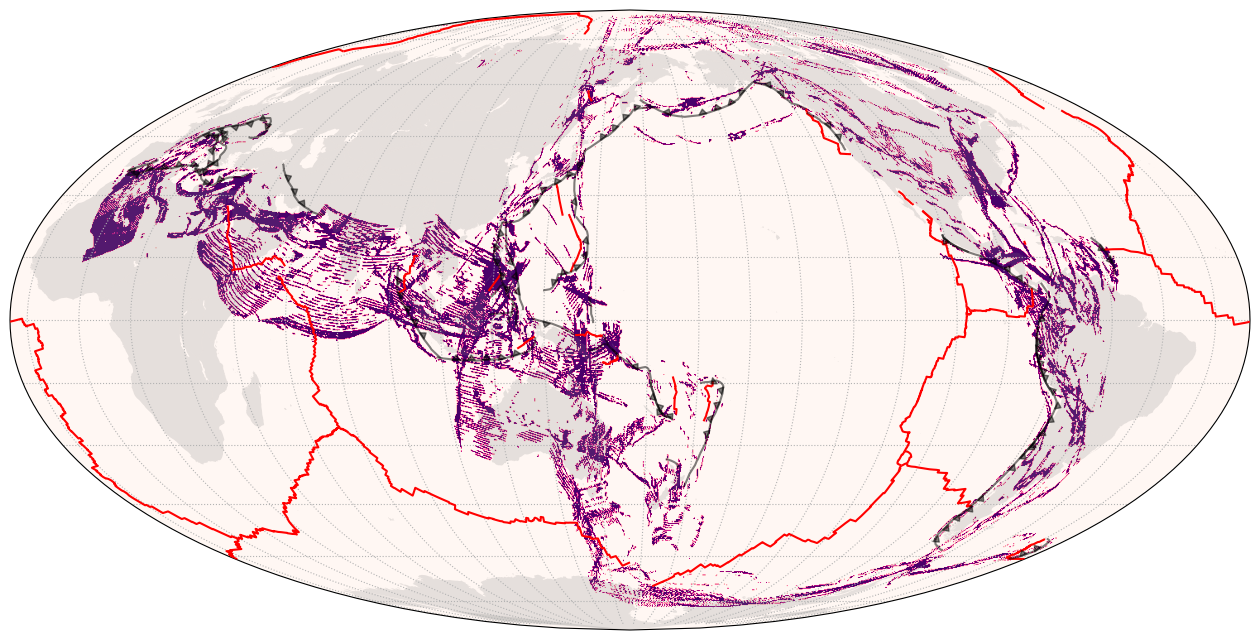

In [12]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 160))
ax.set_global()
ax.gridlines(color='0.7',linestyle=':', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 0 # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_grid(ax, subducted_fz_grid, origin='lower', cmap='RdPu', )
gplot.plot_coastlines(ax, color='0.5', alpha=0.2)
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

gplot.plot_trenches(ax, color='k', zorder=9, alpha=0.5)
gplot.plot_subduction_teeth(ax, color='k', zorder=10, alpha=0.5)


In [13]:
# mask out zero regions
subducted_fz_time_grid2 = subducted_fz_time_grid.copy()

subducted_fz_time_grid2[subducted_fz_time_grid == 0] = np.nan

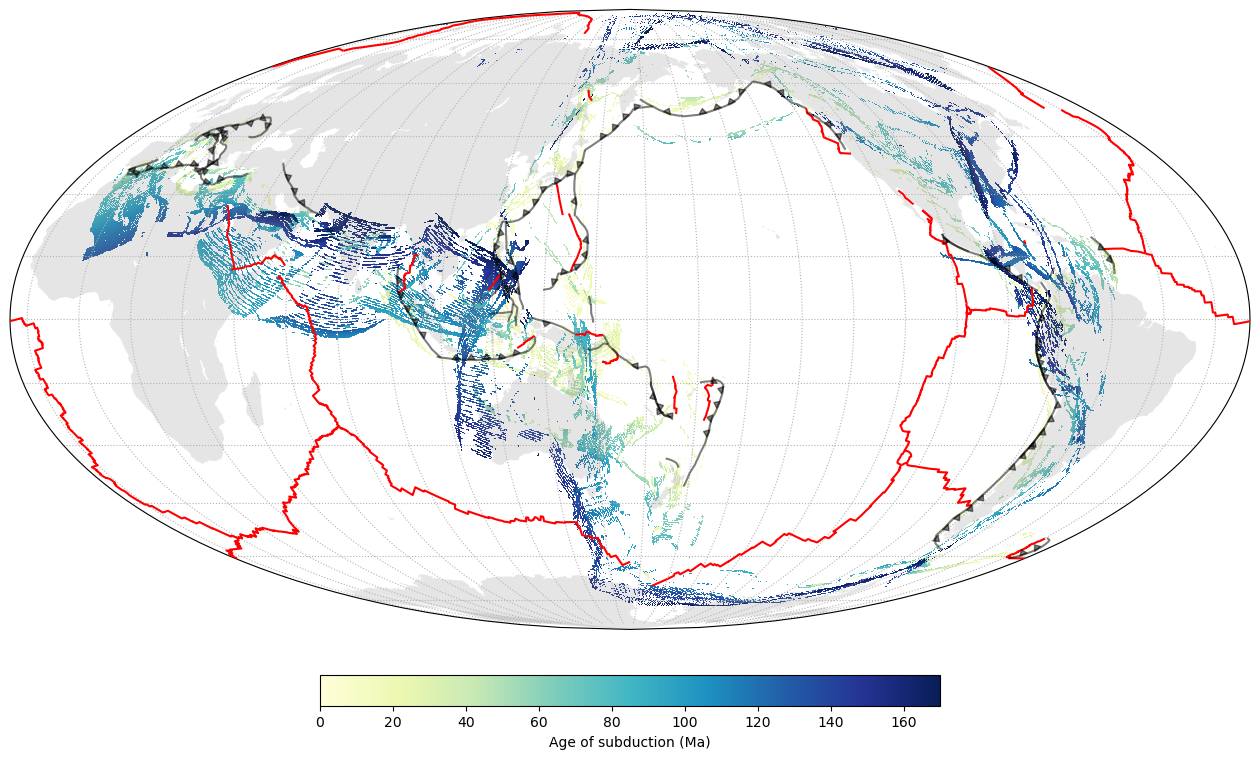

In [14]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 160))
ax.set_global()
ax.gridlines(color='0.7',linestyle=':', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 0 # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
im = gplot.plot_grid(ax, subducted_fz_time_grid2, origin='lower', cmap='YlGnBu', interpolation='None', vmin=0)
gplot.plot_coastlines(ax, color='0.5', alpha=0.2)
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

gplot.plot_trenches(ax, color='k', zorder=9, alpha=0.5)
gplot.plot_subduction_teeth(ax, color='k', zorder=10, alpha=0.5)

fig.colorbar(im, shrink=0.5, pad=0.05, orientation='horizontal', label='Age of subduction (Ma)')

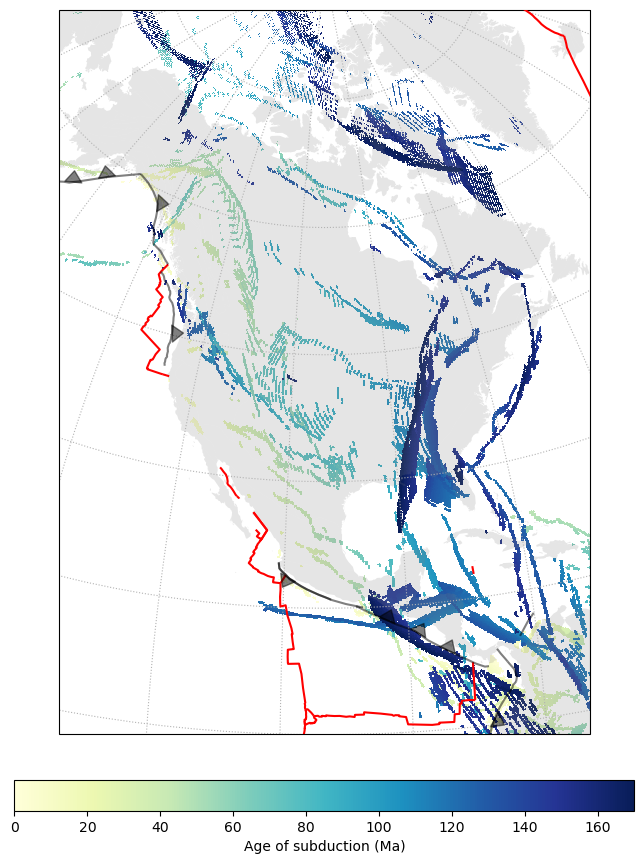

In [15]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.AzimuthalEquidistant(-100, 30))
ax.set_extent([-130, -70, 0, 85])
ax.gridlines(color='0.7',linestyle=':', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 0 # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
im = gplot.plot_grid(ax, subducted_fz_time_grid2, origin='lower', cmap='YlGnBu', interpolation='None', vmin=0)
gplot.plot_coastlines(ax, color='0.5', alpha=0.2)
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

gplot.plot_trenches(ax, color='k', zorder=9, alpha=0.5)
gplot.plot_subduction_teeth(ax, color='k', zorder=10, alpha=0.5)

fig.colorbar(im, shrink=0.5, pad=0.05, orientation='horizontal', label='Age of subduction (Ma)')

## Save data

In [16]:
subducted_grid = gplately.Raster(array=subducted_fz_time_grid2, extent='global')
subducted_grid.save_to_NetCDF4('subducted_fz_ages.nc')

In [17]:
fz_data_dict = dict()

for i, time in enumerate(reconstruction_times):
    fz_data_dict[str(time)] = fz_data[i]
    
np.savez_compressed('subducted_fz_data.npz', **fz_data_dict)